In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import math
from pandas_datareader import data as pdr

In [499]:
# etfs = ['XLF','XLK','XLE','XLV','XLI','XBI','XLU','XLP','XLY','KRE','XLB','XLC','XRT','XOP','XLRE','XHB','KBE','XME','KIE','XSD','XAR','XES','KCE','XNTK','XHE','XSW','XPH','XTN','XHS','XITK','XTL']
# etfs = [etf for etf in etfs if etf not in ['XLRE', 'XITK', 'XLC']]
etfs = ['XLI', 'XLF', 'XLK']
prices = yf.download(tickers=etfs, period='max')['Close']
prices

[*********************100%***********************]  3 of 3 completed


Ticker,XLF,XLI,XLK
Date,,,
1998-12-22,11.297121,14.582217,23.943209
1998-12-23,11.463700,14.836672,24.515236
1998-12-24,11.539417,15.032405,24.421837
1998-12-28,11.387995,15.110702,24.491884
1998-12-29,11.509135,15.326001,24.561922
...,...,...,...
2025-06-26,51.790001,145.339996,251.070007
2025-06-27,51.939999,146.789993,250.770004
2025-06-30,52.369999,147.520004,253.229996


In [308]:
start_dates = {}
for col in prices.columns:
    start_dates[col] = prices[col].dropna().index[0]
start_dates = pd.Series(start_dates)
start_dates.sort_values()

XLI    1998-12-22
XLY    1998-12-22
XLV    1998-12-22
XLU    1998-12-22
XLP    1998-12-22
XLK    1998-12-22
XLF    1998-12-22
XLE    1998-12-22
XLB    1998-12-22
XNTK   2000-10-02
KBE    2005-11-15
KCE    2005-11-15
KIE    2005-11-15
XSD    2006-02-06
XHB    2006-02-06
XBI    2006-02-06
KRE    2006-06-22
XRT    2006-06-22
XPH    2006-06-22
XES    2006-06-22
XOP    2006-06-22
XME    2006-06-22
XTN    2011-01-27
XTL    2011-01-27
XHE    2011-01-27
XAR    2011-09-29
XSW    2011-09-29
XHS    2011-09-29
XLRE   2015-10-08
XITK   2016-01-14
XLC    2018-06-19
dtype: datetime64[ns]

In [22]:
import industry_trends as it
import db.schemas as schemas

job = schemas.IndustryTrendsJobBase(
    initial_balance=100_000,
    start_date=pd.to_datetime('2006-01-01'),
    end_date=pd.to_datetime('2024-05-01'),
    tickers=it.etfs,
    user='*',
    benchmark='SPY',
)
results = it.trend_following_strategy(job)

Index(['Return'], dtype='object')
Index(['Return', 'Year', 'Month'], dtype='object')


<string>:155: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


In [23]:
results.balance

,Equity,Holdings,Cash,Borrowed,SPY
Date,,,,,
2006-01-03,100000.000000,0.000000,100000.000000,0.0,100000.000000
2006-01-04,100000.000000,0.000000,100000.000000,0.0,100473.592681
2006-01-05,100000.000000,0.000000,100000.000000,0.0,100536.664360
2006-01-06,100000.000000,0.000000,100000.000000,0.0,101373.352857
2006-01-09,100000.000000,0.000000,100000.000000,0.0,101633.757711
...,...,...,...,...,...
2024-04-25,81043.566234,1130.782376,79912.783857,0.0,563516.589578
2024-04-26,81054.383418,1111.415865,79942.967553,0.0,568855.270705
2024-04-29,81066.752444,1099.143647,79967.608798,0.0,570869.817608


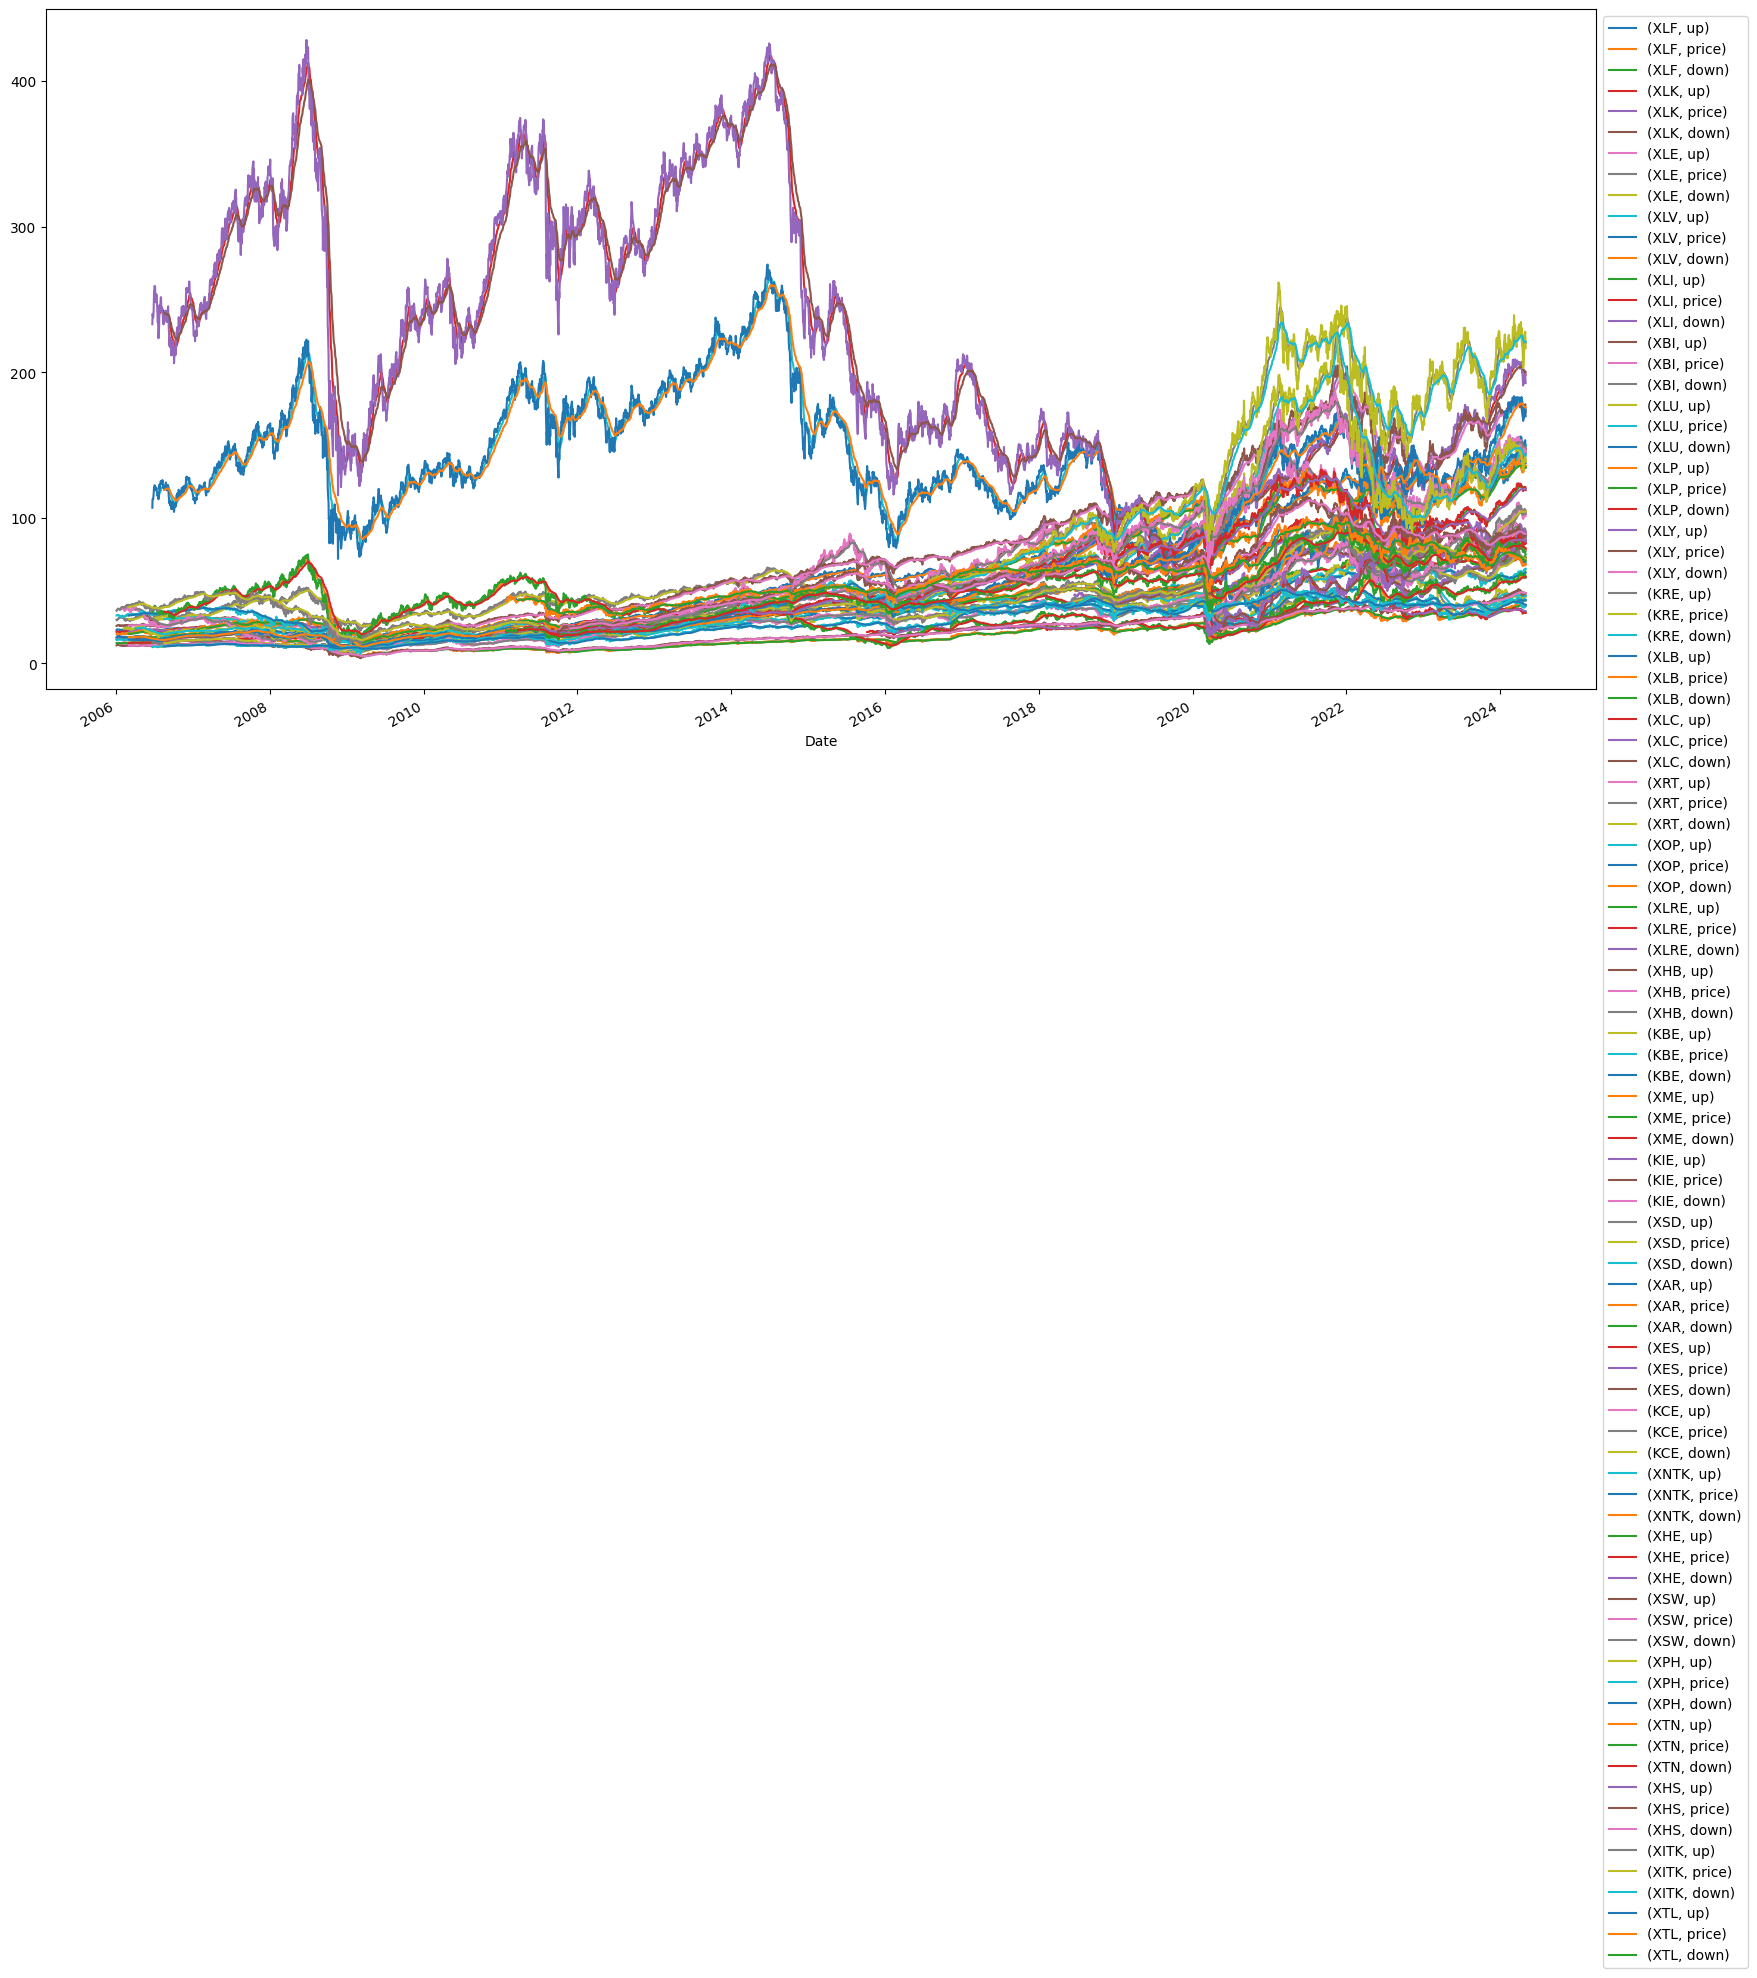

In [24]:
results.channels.plot(figsize=(20, 10)).legend(bbox_to_anchor=(1.0, 1.0))

In [5]:
results.tx_costs.sum()

np.float64(2039.099999999999)

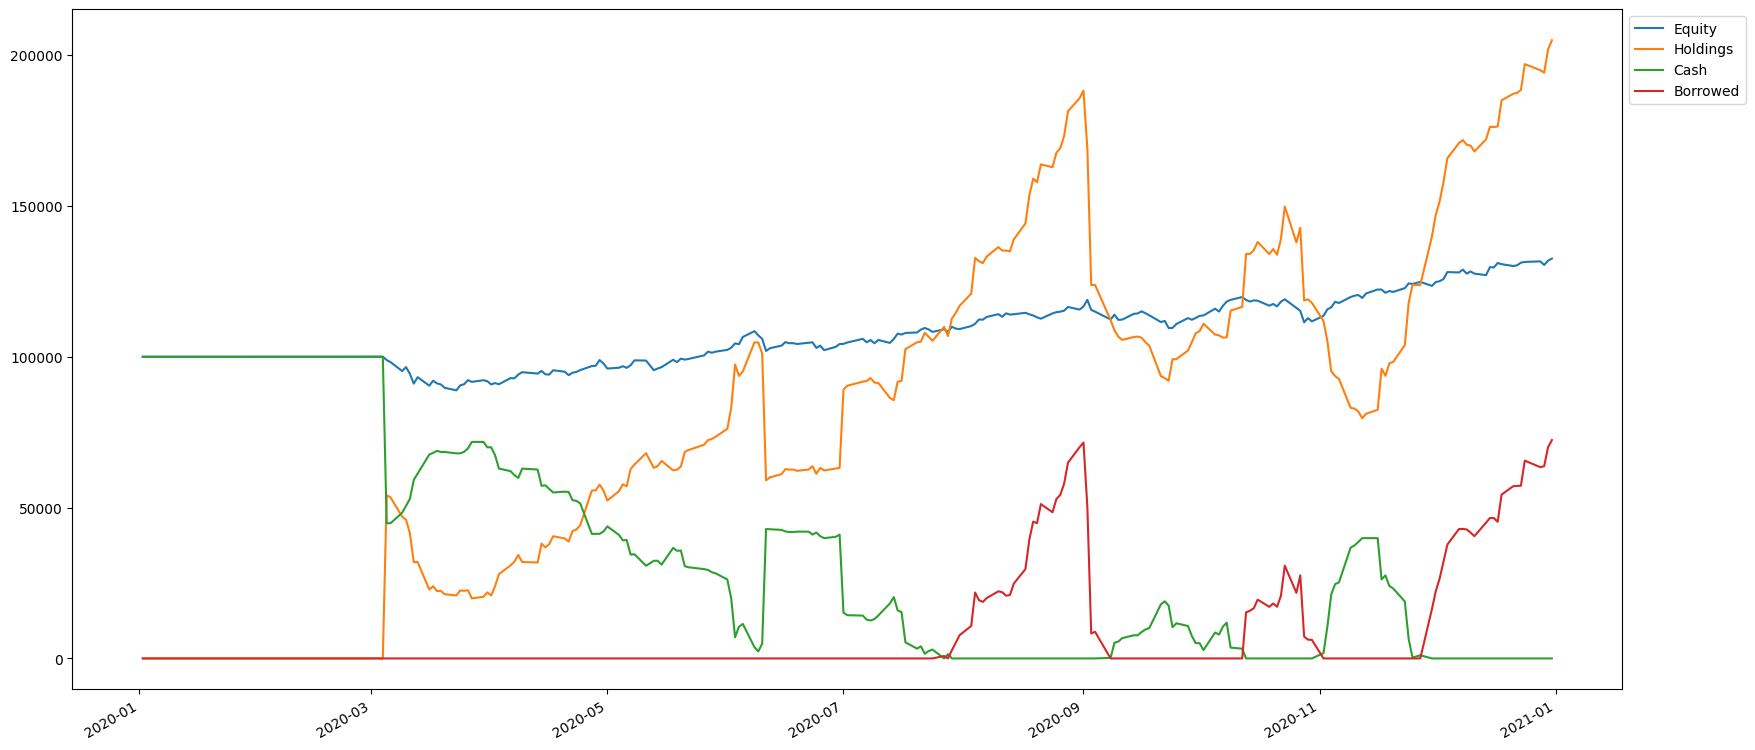

In [538]:
pd.concat([results.equity, results.holdings, results.cash, results.borrowed], axis=1).rename(columns={0: 'Equity', 1: 'Holdings', 2: 'Cash', 3: 'Borrowed'}).plot(figsize=(20, 10)).legend(bbox_to_anchor=(1.0, 1.0))

In [548]:
results.shares.diff().fillna(0).astype(bool).sum().sum()

,KBE,KCE,KIE,KRE,XAR,XBI,XES,XHB,XHE,XHS,...,XLY,XME,XNTK,XOP,XPH,XRT,XSD,XSW,XTL,XTN
2020-01-02,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-06,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-07,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-08,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.0,17.319527,0.000000,0.0,5.136278,0.000000,15.780682,0.0,0.0,0.000000,...,0.0,17.248737,0.000000,7.526353,0.0,0.0,0.000000,0.000000,0.000000,16.745552
2020-12-28,0.0,0.000000,49.383883,0.0,0.000000,-4.197452,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,4.639326,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2020-12-29,0.0,-16.579864,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,8.501727,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,-11.487134,0.000000
2020-12-30,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,14.045390,0.000000,0.0,0.0,4.808081,0.000000,9.181509,0.000000


In [477]:
equity.groupby(pd.Grouper(freq='ME')).nth(-1).pct_change() * 100

2005-01-31          NaN
2005-02-28     0.000000
2005-03-31    -5.791343
2005-04-29    -4.049173
2005-05-31     7.902956
                ...    
2023-12-29    10.375402
2024-01-31     1.688451
2024-02-29     8.824674
2024-03-28     7.564722
2024-04-01    -0.815313
Length: 232, dtype: float64

In [15]:
type(results.balance)

',0\n2020-01-02,100000.0\n2020-01-03,100000.0\n2020-01-06,100000.0\n2020-01-07,100000.0\n2020-01-08,100000.0\n2020-01-09,100000.0\n2020-01-10,100000.0\n2020-01-13,100000.0\n2020-01-14,100000.0\n2020-01-15,100000.0\n2020-01-16,100000.0\n2020-01-17,100000.0\n2020-01-21,100000.0\n2020-01-22,100000.0\n2020-01-23,100000.0\n2020-01-24,100000.0\n2020-01-27,100000.0\n2020-01-28,100000.0\n2020-01-29,100000.0\n2020-01-30,100000.0\n2020-01-31,100000.0\n2020-02-03,100000.0\n2020-02-04,100000.0\n2020-02-05,100000.0\n2020-02-06,100000.0\n2020-02-07,100000.0\n2020-02-10,100000.0\n2020-02-11,100000.0\n2020-02-12,100000.0\n2020-02-13,100000.0\n2020-02-14,100000.0\n2020-02-18,100000.0\n2020-02-19,100000.0\n2020-02-20,100000.0\n2020-02-21,100000.0\n2020-02-24,100000.0\n2020-02-25,100000.0\n2020-02-26,100000.0\n2020-02-27,100000.0\n2020-02-28,100000.0\n2020-03-02,100005.71281408126\n2020-03-03,100011.26944444608\n2020-03-04,100015.65052894641\n2020-03-05,100006.96407793049\n2020-03-06,100001.62508891219\n